In [1]:
import torch
import os
import numpy as np
from transformers import Swinv2Model, Swinv2ForImageClassification, AutoImageProcessor
from torchvision.transforms import (
    Normalize,
    Lambda,
    Resize,
    CenterCrop,
    ToTensor,
    Compose,
)
from torchvision import datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm.notebook import tqdm

TEST_DIR = "../data/processed/15spp_zoom_level_validation_models/1-seed/test"  # adjust path as needed
CHECKPOINT_PATH = "../models/15spp_zoom_level_validation_models/1_seed_model_20250127/checkpoint-18000"  # adjust path as needed
# RESIZE = 256
# IMAGE_SIZE = 192


In [2]:

# # Load the checkpoint
# checkpoint = torch.load(CHECKPOINT_PATH)

# # Assuming the checkpoint contains model state dict
# model_state_dict = checkpoint['model_state_dict']

# # Create model instance (replace with your model architecture)
# model = Swinv2Model()  # Define your model class
# model.load_state_dict(model_state_dict)

model = Swinv2ForImageClassification.from_pretrained(CHECKPOINT_PATH)
model.eval()  # Set to evaluation mode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0): Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=6, bias=False)
                  )
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192

In [3]:

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained(CHECKPOINT_PATH)

# Define torchvision transforms to be applied to each image.
if "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
else:
    size = (image_processor.size["height"], image_processor.size["width"])

print("SIZE : ", size)
normalize = (
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    if hasattr(image_processor, "image_mean") and hasattr(image_processor, "image_std")
    else Lambda(lambda x: x)
)

# Define transformations
transform = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


SIZE :  (192, 192)


In [4]:

# Load test dataset from local folder
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)

# Get the class to index mapping
class_to_idx = test_dataset.class_to_idx

# Invert the dictionary to get index to class mapping
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the mapping
print(idx_to_class)

BATCH_SIZE = 32
# Create data loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


{0: '0 Brassica napus', 1: '1 Brassica junsea', 2: '10 Solanum nigrum', 3: '11 Solanum rostratum', 4: '12 Ambrosia artemisiifolia', 5: '13 Ambrosia trifida', 6: '14 Ambrosia psilostachya', 7: '2 Cirsium arvense', 8: '3 Cirsium vulgare', 9: '4 Carduus nutans', 10: '5 Bromus secalinus', 11: '6 Bromus hordeaceus', 12: '7 Bromus japonicus', 13: '8 Lolium temulentum', 14: '9 Solanum carolinense'}


In [5]:
total_samples = len(test_dataset.imgs)
progress_bar = tqdm(total=total_samples, desc="Test set inference", unit="samples")

# Initialize lists to store predictions and ground truth
predictions = []
y_test = []

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        # Get predictions
        _, preds = torch.max(outputs.logits, 1)

        # Append batch predictions and labels
        predictions.extend(preds.cpu().numpy())
        y_test.extend(labels.cpu().numpy())
        progress_bar.update(BATCH_SIZE)

# Convert lists to numpy arrays
predictions = np.array(predictions)
y_test = np.array(y_test)


Test set inference:   0%|          | 0/1082 [00:00<?, ?samples/s]

In [6]:
with torch.no_grad():
    torch.cuda.empty_cache()

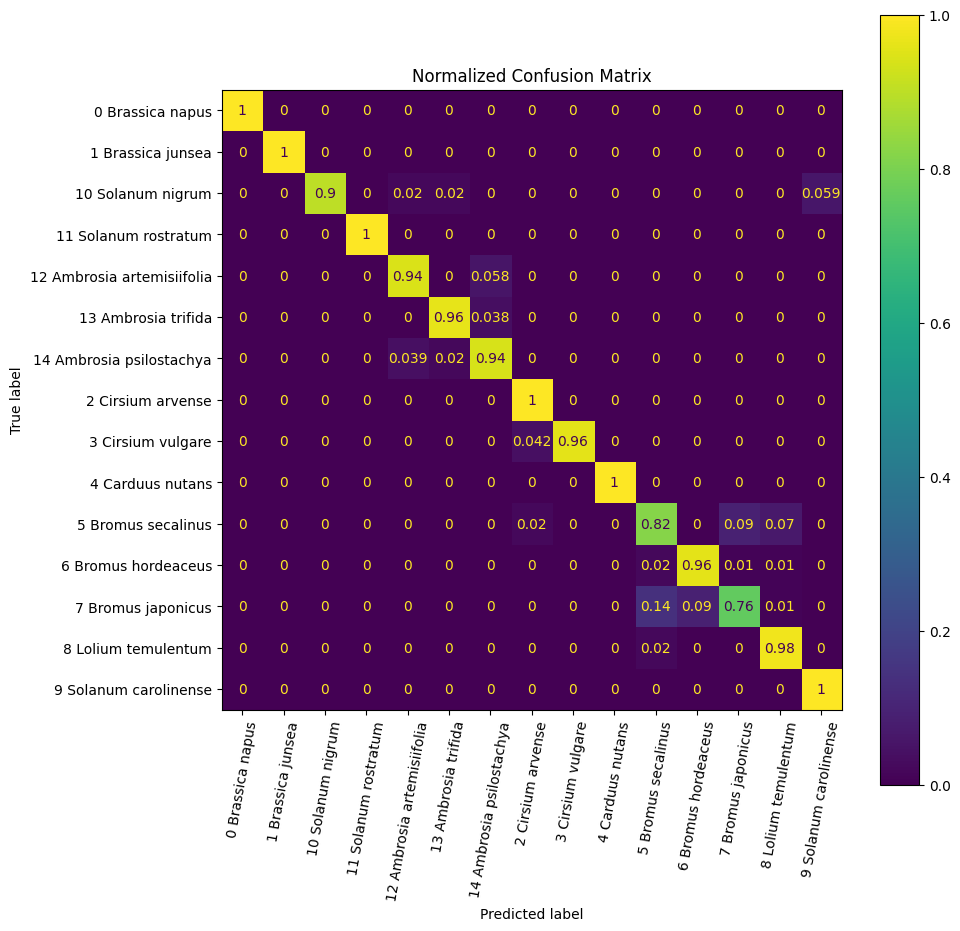

In [9]:

import matplotlib.pyplot as plt
# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display non-normalized confusion matrix
# disp = ConfusionMatrixDisplay(
#     cm, display_labels=[idx_to_class[i] for i in range(len(idx_to_class))]
# )
# disp.plot()

# Compute normalized confusion matrix
cm_normalized = confusion_matrix(y_test, predictions, normalize="true")

# Display normalized confusion matrix
disp_normalized = ConfusionMatrixDisplay(
    cm_normalized, display_labels=[idx_to_class[i] for i in range(len(idx_to_class))]
)
# disp_normalized.plot()
# disp.plot()
# disp.ax_.set_title("Non-Normalized Confusion Matrix")
# plt.xticks(rotation=80)
fig, ax = plt.subplots(figsize=(10, 10))
disp_normalized.plot(ax=ax)
disp_normalized.ax_.set_title("Normalized Confusion Matrix")
plt.xticks(rotation=80)
plt.show()

In [8]:

# Generate classification report
report = classification_report(y_test, predictions, target_names=[idx_to_class[i] for i in range(len(idx_to_class))])

# Print the classification report
print(report)

                            precision    recall  f1-score   support

          0 Brassica napus       1.00      1.00      1.00       105
         1 Brassica junsea       1.00      1.00      1.00       114
         10 Solanum nigrum       1.00      0.90      0.95        51
      11 Solanum rostratum       1.00      1.00      1.00        50
12 Ambrosia artemisiifolia       0.94      0.94      0.94        52
       13 Ambrosia trifida       0.96      0.96      0.96        53
  14 Ambrosia psilostachya       0.91      0.94      0.92        51
         2 Cirsium arvense       0.93      1.00      0.96        52
         3 Cirsium vulgare       1.00      0.96      0.98        48
          4 Carduus nutans       1.00      1.00      1.00        55
        5 Bromus secalinus       0.82      0.82      0.82       100
       6 Bromus hordeaceus       0.91      0.96      0.94       100
        7 Bromus japonicus       0.88      0.76      0.82       100
       8 Lolium temulentum       0.92      0.98